In [1]:
# from neo4j import GraphDatabase

# uri = "bolt://localhost:7687"
# user = "neo4j"
# password = "m2x1m0s001613"

# driver = GraphDatabase.driver(uri, auth=(user, password))

# def create_graph(tx):
#     tx.run("""
#         CREATE (p:Paper {title: "Graph Learning"})
#         CREATE (a:Author {name: "You"})
#         CREATE (a)-[:WROTE]->(p)
#     """)

# with driver.session() as session:
#     session.execute_write(create_graph)

# driver.close()


In [2]:
# from yfiles_jupyter_graphs import GraphWidget

# driver = GraphDatabase.driver(uri, auth=(user, password))

# with driver.session() as session:
#     result = session.run("MATCH (n)-[r]->(m) RETURN n, r, m")
#     widget = GraphWidget(result.graph())
#     widget

In [3]:
# import requests
# from bs4 import BeautifulSoup
# from urllib.parse import urljoin, urlparse
# import os

# output_dir = "Sherlock"
# os.makedirs(output_dir, exist_ok=True)

# if len(os.listdir(output_dir)) == 0:
#     base_url = "https://sherlock-holm.es/ascii/"

#     # 1. GET the page
#     response = requests.get(base_url)
#     response.raise_for_status()  # stop if HTTP errors

#     soup = BeautifulSoup(response.text, "html.parser")

#     txt_links = []

#     # 2. Find all <a> tags
#     for a in soup.find_all("a"):
#         href = a.get("href")
#         if not href:
#             continue

#         # 3. Normalize the link to an absolute URL
#         full_url = urljoin(base_url, href)

#         # 4. Check if the URL ends with .txt
#         if full_url.lower().endswith(".txt"):
#             txt_links.append(full_url)

#     # Print results
#     for url in txt_links:
#         # Extract filename from URL
#         filename = os.path.basename(urlparse(url).path)
#         output_path = os.path.join(output_dir, filename)

#         print(f"Downloading {filename}...")

#         r = requests.get(url)
#         r.raise_for_status()

#         # Write as binary to be safe
#         with open(output_path, "wb") as f:
#             f.write(r.content)


In [4]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_core.documents import Document
from langchain_ollama import ChatOllama
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.prompts import ChatPromptTemplate

In [5]:
retriever = WikipediaRetriever()
docs = retriever.invoke("Appolo 11")
text = docs[0].page_content
print(text)

Apollo 11 (July 16–24, 1969) was the fifth manned flight in the United States Apollo program and the first spaceflight to land humans on the Moon. Commander Neil Armstrong and Lunar Module Pilot Edwin "Buzz" Aldrin landed the Lunar Module Eagle on July 20 at 20:17 UTC, and Armstrong became the first person to step onto the surface about six hours later, at 02:56 UTC on July 21. Aldrin joined him 19 minutes afterward, and together they spent about two and a half hours exploring the site they had named Tranquility Base upon landing. They collected 47.5 pounds (21.5 kg) of lunar material before re-entering the Lunar Module. In total, they were on the Moon’s surface for 21 hours, 36 minutes before returning to the Command Module Columbia, which remained in lunar orbit, piloted by Michael Collins.
Apollo 11 was launched by a Saturn V rocket from Kennedy Space Center in Florida, on July 16 at 13:32 UTC (9:32 am EDT, local time). The Apollo spacecraft consisted of three parts: the command mod

In [6]:
# Initialize the ChatOllama model with the specified model name
# model_name = 'qwen3-vl:4b'
model_name = 'llama3.2:3b'  # Or another text-focused model

# and initialize the ChatOllama instance
chat_model = ChatOllama(
    model=model_name,
    validate_model_on_init=True,
    temperature=0.7
)

In [7]:
# Create a ChatPromptTemplate for graph extraction
graph_extraction_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert at extracting entities and relationships from text to build knowledge graphs.
Try to retain the most useful entities and relations for the story to be as complete as possible.
Focus on:
- Named entities (people, places, organizations, events)
- Relationships and interactions between entities
- Relevant attributes and properties
"""),
    ("human", "{input}")
])

In [8]:
no_schema = LLMGraphTransformer(
    llm=chat_model,
    prompt=graph_extraction_prompt,
)

In [9]:
# with open('Sherlock/scan.txt', 'r') as file:
#     text = file.read().replace('\n', '')
# print(text)

In [10]:
# text = """
# Marie Curie, 7 November 1867 – 4 July 1934, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
# She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
# Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
# She was, in 1906, the first woman to become a professor at the University of Paris.
# Also, Robin Williams.
# """

In [11]:
documents = [Document(page_content=text)]

In [12]:
print(documents)

[Document(metadata={}, page_content='Apollo 11 (July 16–24, 1969) was the fifth manned flight in the United States Apollo program and the first spaceflight to land humans on the Moon. Commander Neil Armstrong and Lunar Module Pilot Edwin "Buzz" Aldrin landed the Lunar Module Eagle on July 20 at 20:17 UTC, and Armstrong became the first person to step onto the surface about six hours later, at 02:56 UTC on July 21. Aldrin joined him 19 minutes afterward, and together they spent about two and a half hours exploring the site they had named Tranquility Base upon landing. They collected 47.5 pounds (21.5 kg) of lunar material before re-entering the Lunar Module. In total, they were on the Moon’s surface for 21 hours, 36 minutes before returning to the Command Module Columbia, which remained in lunar orbit, piloted by Michael Collins.\nApollo 11 was launched by a Saturn V rocket from Kennedy Space Center in Florida, on July 16 at 13:32 UTC (9:32 am EDT, local time). The Apollo spacecraft con

In [13]:
graph_no_schema = no_schema.convert_to_graph_documents(documents)

In [14]:
print(graph_no_schema)

[GraphDocument(nodes=[Node(id='Aspacecraft', type='Organization/event', properties={}), Node(id='Apollo 11', type='Spaceflight/crewed mission', properties={}), Node(id='Saturn V', type='Rocket', properties={}), Node(id='Kennedy Space Center', type='Location/establishment', properties={}), Node(id='United States', type='Country/organization', properties={}), Node(id='Soviet Union', type='Country/organization', properties={}), Node(id='Space Race', type='Event/geopolitical event', properties={}), Node(id='National Aeronautics And Space Administration (Nasa)', type='Organization/government agency', properties={}), Node(id='Project Mercury', type='Spaceflight program', properties={}), Node(id='Tranquility Base', type='Location', properties={}), Node(id='Mare Tranquillitatis', type='Location', properties={}), Node(id='Lunar Module Eagle', type='Spacecraft/component', properties={}), Node(id='Command Module Columbia', type='Spacecraft/component', properties={}), Node(id='Lunar Orbit', type='

In [15]:
import os
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph

# Load environment variables from .env file
load_dotenv()

# Get credentials from environment variables
neo4j_url = os.getenv("NEO4J_URL", "bolt://localhost:7687")
neo4j_user = os.getenv("NEO4J_USER", "neo4j")
neo4j_password = os.getenv("NEO4J_PASSWORD")

if not neo4j_password:
    raise ValueError("NEO4J_PASSWORD environment variable is not set. Please create a .env file with your credentials.")

graph = Neo4jGraph(
    url=neo4j_url,
    username=neo4j_user,
    password=neo4j_password
)

In [16]:
print(type(graph))

<class 'langchain_neo4j.graphs.neo4j_graph.Neo4jGraph'>


In [17]:
graph.add_graph_documents(graph_no_schema)

In [18]:
# graph.query("MATCH (n) DETACH DELETE n;")
# graph.query("MATCH (n) RETURN n;")

## Visualize Graph as Static Image

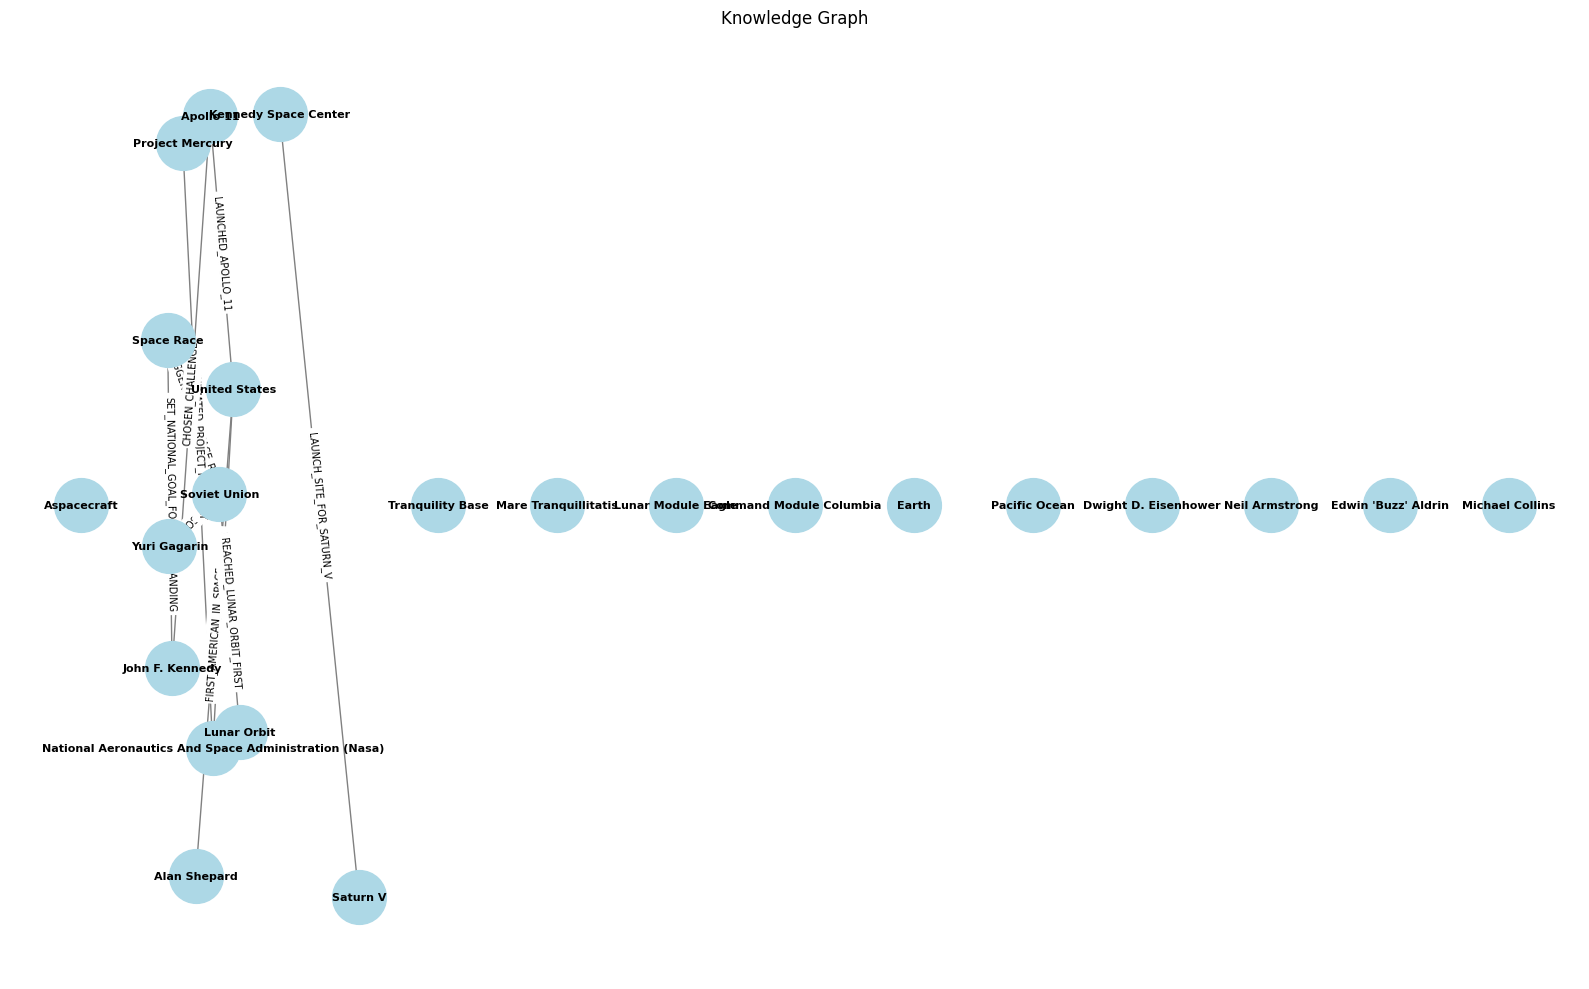

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert graph documents to NetworkX graph
G = nx.DiGraph()

for doc in graph_no_schema:
    # Add nodes
    for node in doc.nodes:
        G.add_node(node.id, label=node.type)
    
    # Add edges
    for rel in doc.relationships:
        G.add_edge(rel.source.id, rel.target.id, label=rel.type)

# Get connected components (treating as undirected to find connected parts)
G_undirected = G.to_undirected()
components = list(nx.connected_components(G_undirected))

# Position each component separately
pos = {}
x_offset = 0
for component in components:
    # Create subgraph for this component
    subgraph = G.subgraph(component)
    # Layout this component
    component_pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    # Shift component positions to avoid overlap
    for node, (x, y) in component_pos.items():
        pos[node] = (x + x_offset, y)
    
    # Offset for next component
    x_offset += 3

# Visualize as static image
plt.figure(figsize=(16, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7)

plt.title("Knowledge Graph")
plt.axis('off')
plt.tight_layout()
plt.savefig('graph_static.png', dpi=150, bbox_inches='tight')
plt.show()

## Alternative: Interactive Visualization with Pyvis

In [20]:
from pyvis.network import Network

# Create Pyvis network
net = Network(directed=True, notebook=True, height="750px", width="100%")

# Add nodes and edges from graph documents
for doc in graph_no_schema:
    for node in doc.nodes:
        # Show the actual entity name as label, and its type as hover title
        net.add_node(node.id, label=node.id, title=f"Type: {node.type}")
    
    for rel in doc.relationships:
        # Show relationship type as label, with source->target info in title
        net.add_edge(
            rel.source.id, 
            rel.target.id, 
            title=f"{rel.source.id} -[{rel.type}]-> {rel.target.id}",
            label=rel.type
        )

# Customize physics
net.show_buttons(filter_=['physics'])
net.save_graph('graph.html')